## Задача 1

Рассчитать Retention и создать функцию, которая будет вычислять Retention игроков, учитывая количество дней с момента их регистрации.

**reg_data.csv** – данные о времени регистрации

**auth_data.csv** – данные о времени захода пользователей в игру


In [2]:
# импортируем необходимые для работы библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import pingouin as pg
from scipy import stats
from scipy.stats import ttest_ind

In [3]:
# загружаем файлы в датафрейме и смотрим на данные
reg_data = pd.read_csv("problem1-reg_data.csv", sep=";")
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
auth_data = pd.read_csv("problem1-auth_data.csv", sep=";")
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


Проводим предообработку данных, которые мы загрузили

In [6]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [7]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [8]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [9]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [10]:
auth_data.uid.nunique() # смотрим сколько у нас уникальных пользователей

1000000

Отлично, пропущенных значений у нас нет. Переведем данные `reg_ts` и  `auth_ts` в формат даты, так как данные у нас указаны в Unix формате и посмотрим за какой период у нас дата сеты. 

In [11]:
reg_data["reg_ts"] = pd.to_datetime(reg_data["reg_ts"], unit='s')
reg_data.head()

,reg_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,2000-01-13 22:27:27,3
3,2000-05-28 14:19:01,4
4,2000-09-16 11:21:53,5


In [12]:
reg_data.dtypes

reg_ts    datetime64[ns]
uid                int64
dtype: object

In [13]:
reg_data.reg_ts.min()

Timestamp('1998-11-18 09:43:43')

In [14]:
reg_data.reg_ts.max()

Timestamp('2020-09-23 15:17:24')

In [15]:
auth_data["auth_ts"] = pd.to_datetime(auth_data["auth_ts"], unit='s')

In [16]:
auth_data.auth_ts.max()

Timestamp('2020-09-23 15:17:24')

In [17]:
auth_data.auth_ts.min()

Timestamp('1998-11-18 09:43:43')

Пишем функцию для расчета  retention, так как период данных большой сделаем функцию с параметрами выбора промежутка дат

In [18]:
def retention(reg_data, auth_data, start_date, end_date):
    
    '''
    Для подсчета retention функция будет принимать четыре параметра:
    reg_data - данные о времени регистрации
    auth_data -  данные о времени захода пользователей в игру
    start date - начальная дата 
    end date - конечная дата
    '''
    
    #Переводим дату из Unix формата в datetime64
  
    reg_data["reg_ts"] = pd.to_datetime(reg_data["reg_ts"], unit='s').dt.normalize()
    auth_data["auth_ts"] = pd.to_datetime(auth_data["auth_ts"], unit='s').dt.normalize()
     
    
    #Объединяем данные из двух таблиц в одну:
    
    reg_data =  reg_data.query("reg_ts >= @start_date")
    auth_data = auth_data.query("auth_ts <= @end_date")
    join_data = pd.merge(reg_data, auth_data, on="uid")
    
   
    #Добавлялем новый столбец с разницей в днях между регистрацией и входа:
    join_data ['days'] = (join_data['auth_ts'] - join_data['reg_ts']).dt.days 
    
    #Группируем когорты
    join_data = join_data\
        .groupby(['reg_ts', 'days'], as_index = False)\
        .agg({'uid':'nunique'}) \
        .pivot(index='reg_ts', columns='days', values='uid')
        
    #Рассчитаем retention
    retention = join_data.divide(join_data.iloc[:,0], axis=0).round(4)
    
   # Делаем визуализацию результатов
    plt.figure(figsize=(20,10))
    ax = sns.heatmap(retention, vmax=0.1, vmin=0.0, annot=True, fmt='.2%', cmap='coolwarm')
    plt.title(' Retention', size= 15)
    plt.xlabel('days',size= 12)
    plt.ylabel('сohorts', size= 12)
    plt.show()

Проверяем нашу функцию

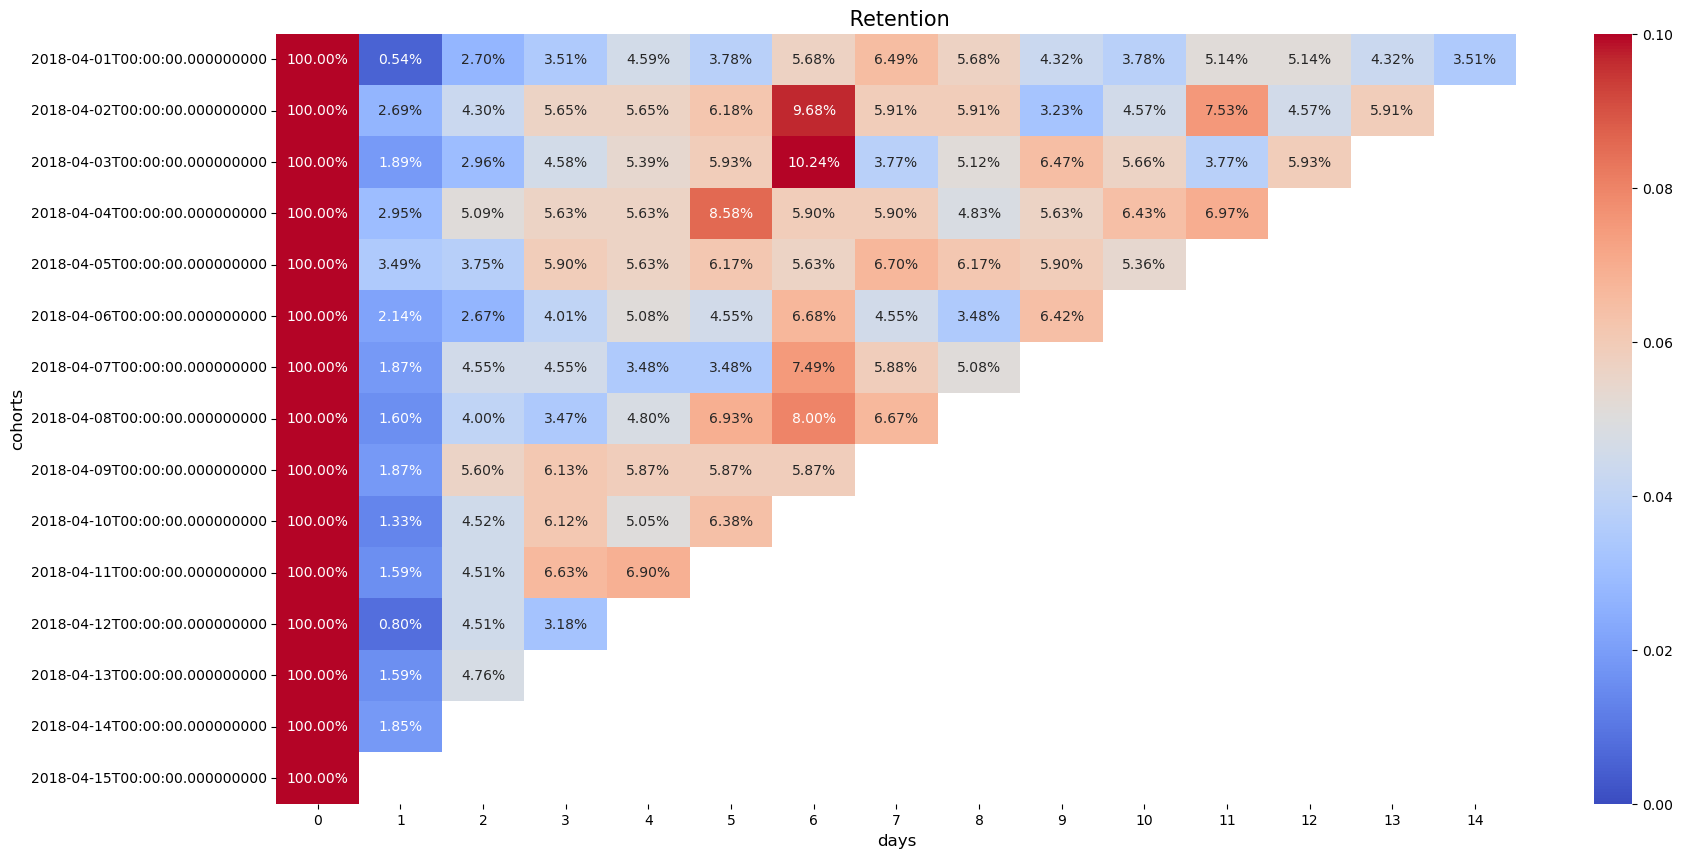

In [19]:
retention(reg_data, auth_data, '2018-04-01', '2018-04-15')

# Задача 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Требуется ответить на следующие вопросы:
* Какой набор предложений можно считать лучшим? 
* Какие метрики стоит проанализировать для принятия правильного решения и как?

In [20]:
# загружаем данные и смотрим наего структуру
ab_df = pd.read_csv('Проект_1_Задание_2.csv', sep=';')
ab_df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [21]:
ab_df.shape

(404770, 3)

In [22]:
ab_df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [23]:
ab_df.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

In [24]:
ab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


Проверяем условия которые нам были даны. Данные по количеству игроков в группе и сколько из них являются платящими.

In [25]:
ab_df.groupby('testgroup', as_index=False) \
    .agg({'user_id':'nunique'})

,testgroup,user_id
0,a,202103
1,b,202667


In [26]:
ab_df.query('revenue > 0') \
    .groupby('testgroup', as_index=False) \
    .agg({'user_id':'nunique'})

,testgroup,user_id
0,a,1928
1,b,1805


Всё отлично, данные совпадают с предоставленными данными. Также можем сделать выводы, что контрольная группа это группа A, тестовая группа это группа B.

Хочу посмотреть на распределение групп по платящим клиентам, так как различия небольшие

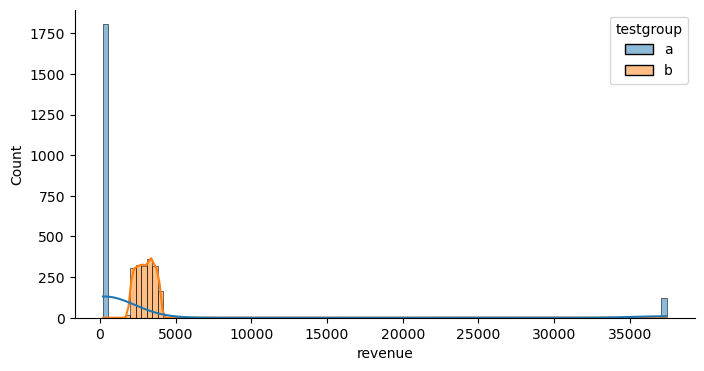

In [27]:
plt.figure(figsize=(8, 4))
sns.histplot(data=ab_df.query('revenue > 0'), x='revenue', hue='testgroup', kde=True)
sns.despine()

На графике распределения чека игроков в контрольной и тестовой группах видно следующее: в контрольной группе наблюдается более равномерное распределение чека игроков, включая и игроков с небольшим чеком, а также с очень большим. В тестовой группе, напротив, чек игроков в основном находится в диапазоне до 5000.

В связи с этим я предполагаю, что сплитирование групп в А/А тесте могло быть выполнено неправильно, что может повлиять на достоверность результатов. В любом случае, мы уже провели А/В тест и я хотел бы проанализировать метрики ARPU, ARPPU и CR для определения, какие изменения в акционных предложениях привели к наиболее эффективным результатам.

Делаем расчет вышеуказанных метрик:

In [28]:
ab_arpu = ab_df.groupby ('testgroup', as_index = False)\
    .agg({'user_id' : 'count', 'revenue':'mean'})\
    .round(2) \
    .rename(columns = {'revenue': 'ARPU'})
ab_arpu

,testgroup,user_id,ARPU
0,a,202103,25.41
1,b,202667,26.75


In [29]:
ab_arppu = ab_df.query('revenue > 0') \
    .groupby ('testgroup', as_index = False)\
    .agg({'user_id' : 'count', 'revenue':'mean'})\
    .round(2) \
    .rename(columns = {'revenue': 'ARPPU', 'user_id': 'pay_user'})
ab_arppu

,testgroup,pay_user,ARPPU
0,a,1928,2664.00
1,b,1805,3003.66


Объединим таблицы ab_arpu и ab_arppu посчитаем CR и выведем для удобства все метри в одну таблицу

In [30]:
metrics = ab_arpu.merge(ab_arppu, on = 'testgroup')
metrics['CR'] = (metrics.pay_user/metrics.user_id).mul(100).round(2)
metrics

,testgroup,user_id,ARPU,pay_user,ARPPU,CR
0,a,202103,25.41,1928,2664.00,0.95
1,b,202667,26.75,1805,3003.66,0.89


Из полученных данных мы видим, что ARPU и ARPPU в тестовой группе выше, но при этом CR в контрольной группе выше и платящих игроков в ней больше. 

Теперь проведем тесты и выясним есть ли статистически значимые различия в метриках между группами. Для этого сначала проверим данные на нормальность и гомогенность.

Посмотрим на результаты и сравним есть ли статистически значимые различия ARPU между группами

In [31]:
# проводим тест на нормальность распределения
pg.normality(data = ab_df, dv = "revenue", group = "testgroup", method = "normaltest")

,W,pval,normal
testgroup,,,
b,326622.395409,0.0,False
a,585152.731273,0.0,False


По результатам теста мы видим, что в обеих группах p-value < 0.05 это говорит о том, что данные распределены ненормально.

In [32]:
# Делаем тест на гомогенность данных
pg.homoscedasticity(data = ab_df, dv = "revenue", group = "testgroup")

,W,pval,equal_var
levene,0.389629,0.532495,True


На основании полученных данных  буду использовать T-тест, потому что данные у нас гомогенны, а то что распределение у нас ненормально это не является стоп фактором, так как у нас выборки большие и работает принцип центральной предельной теоремы.
Сформулируем гипотезы:

Н0 - нет статистически значимых различий между контрольной и тестовой групп

Н1 - есть статистически значимые различия между контрольной и тестовой групп

In [34]:
ttest_ind(ab_df.query('testgroup == "a"').revenue, 
          ab_df.query('testgroup == "b"').revenue)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

Поскольку p-значение больше 0,05, мы отклонить Н0 гипотезу не можем и делаем вывод, что статистически значимых различий между ARPU контрольной и тестовой групп нет.

Посмотрим на метрику ARPPU, также применим Т-тест 

In [35]:
ttest_ind(ab_df.query('testgroup == "a" and revenue > 0').revenue, 
          ab_df.query('testgroup == "b" and revenue > 0').revenue) 

Ttest_indResult(statistic=-1.5917100176862005, pvalue=0.11153459157259496)

Результаты теста показали также p-значение больше 0,05, и делаем вывод, что также статистически значимых различий между ARPPU контрольной и тестовой групп нет. Отклонить Н0 гипотезу мы не можем.

Теперь посмотрим метрику CR как на нее повлияли различные наборы акционных предложений и если статистически значимые различия между группами. Для проверки буду использовать критерий Хи-квадрат, так как сравниваются две категориальные переменные.

In [36]:
# добавлялет дополнительный столбик conversion
ab_df['conversion'] = ab_df['revenue'].apply(lambda x: 1 if x > 0 else 0)
ab_df.head()

,user_id,revenue,testgroup,conversion
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0


In [37]:
stat, p, dof, expected = stats.chi2_contingency(pd.crosstab(ab_df.testgroup, ab_df.conversion))
p

0.03647561892312613

В результате у нас получилось p-значение меньше 0.05, мы отклоняем нулевую гипотезу и делаем вывод, что набор акционных предложений влияет на показатель CR.

## Вывод:

После проведения исследований в контрольной и тестовой группах по метрикам ARPU, ARPPU и CR, сложно однозначно определить, какие наборы акционных предложений можно считать лучшими. Анализ показал, что статистически значимых различий в ARPU и ARPPU между группами не обнаружено. Единственные различия были выявлены в метрике Conversion Rate (CR), однако только на основе этой метрики сложно сделать выводы и утверждать, какие наборы предложений были более успешными.

Также возникает предположение о неправильном сплитировании групп, что могло повлиять на достоверность результатов A/B теста. Возможно, необходимо корректировать сплитирование групп и провести новый A/B тест для получения более точных результатов. После анализа новых данных и результатов нового теста можно будет принять обоснованное решение относительно наилучших наборов акционных предложений.